# News Analysis
## Natural Language Processing, Data Processing and Web Scraping.
Author:[Peter Damyanov](https://github.com/petardmnv)

###### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests

from bs4 import BeautifulSoup

import re
import random

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import WordPunctTokenizer, sent_tokenize
from nltk.stem import PorterStemmer,  WordNetLemmatizer
#nltk.download()
#from nltk.book import *
from datetime import datetime

import collections

import scipy.stats as sp

!pip install sumy
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer

### Research objective

There is an enormous amount of textual material, and it is only growing every single day. Think of the internet, comprised of web pages, news articles, status updates, blogs and so much more. The data is unstructured and the best that we can do to navigate it is to use search and skim the results. There is a great need to reduce much of this text data to shorter, focused summaries that capture the salient details, both so we can navigate it more effectively as well as check whether the larger documents contain the information that we are looking for. Today we live in a fast-paced world where every minute counts, and if we can save time from somewhere, why not save time while reading. In Data Science world, specialists are talking more and more about techniques to analyze text, this field, as already mentioned, is called Natural Language Processing. The summarization process, one of the goals that can be achieved, is extremely useful. Automatic text summarization, or just text summarization, is the process of creating a short and coherent version of a longer document. There are many reasons and uses for a summary of a larger document. One example that might come readily to mind is to create a concise summary of a long news article.
The research objective is to try to implement an algorithm that summarizes news to save some time while reading news.

### Abstract

Clear the path leading to the goal:

    1. Get news data: 
        To get news data we have to ways to act. First - we can get API from site and extract informatio in jason format. Problem with API's: There are not many choises and if you want to push json request inlimited times a day, you would have to pay for this servise. Most of free API's are not working correctly(content from articles are not full, could be corrupted and so on.). Second - we can web scrape the news from news sites and get information as string. Problems with web scraping: It is tricky to web scrape. You could get lost in the proccess. I choosed web scraping because, before that I was struggling  with API's.
        
    2. Store news data - After extracting the news data from these two sites [BBC](https://www.bbc.com/news/business) and [CNN](https://edition.cnn.com/business), I thpught that the best way to store the data is to convert everything to dataframe observations with features - date, news_type, headline and content
    
    3. Text Analysis - After gathering data and storing it in dataframe I had to perform text analysis. Firstable I cleared the text issues. Then removed stopwords from text and performed tokenization on the data into words. To perform summarization I needed to have dictionary with words and their frequencies. I made function that calculates score for every sentence. Score is established by adding every word frequency in the current sentence. Than I compared two different scores by their summarization results. Lastly I compared my summarization with one summarization method from the library sumy and plot results.
    
    4. Results: For every row in the dataframe you can perform summarization method and if you want you can print most frequent words and summarization performance compared to sumy summarization performance.

### Implementing methodology

##### 1.Web Scraping

Get the most popular business news from [CNN](https://edition.cnn.com/business) for the current day.
Get the most popular business news from [BBC](https://www.bbc.com/news/business) for the current day.

**Warning** Scraping two completely different sites is not easy and most of the code will be different. Ie we will not be able to use the functions we have for both sites, but the logic in functions will be almost the same.

In [2]:
cnn_link = 'https://edition.cnn.com/business'
bbc_link = 'https://www.bbc.com/news/business'    

In [3]:
#Get page content
def get_page_content(link):
    page = requests.get(link)
    return page

Secondly we are going to scrape this page, so we can access "top news" urls. To scrape the page we need BeautifulSoup object. 

In [4]:
def create_soup(page):
    soup = BeautifulSoup(page.text, 'html.parser')
    return soup

There are duplicating links so we are going to create function which will remove duplicated links. The easiest way of doing that is to cast "links" to set, because set items are unordered, unchangeable, and do not allow duplicate values.

In [5]:
def clear_duplicate_links(links):
    return list(set(links))

ASDFFGASD

In [6]:
def remove_usless_links(pat, links):
    correct_links = []
    for l in links:
        obj = re.findall(pat, l)
        if len(obj) > 0:
            correct_links.append(obj[0])
    return list(set(correct_links))

Start with CNN

Extact links from scraped data and clear duplicating, if there is such links.

In [7]:
def extract_cnn_links(link):
    page = get_page_content(link)
    soup = create_soup(page)
    cnn_extracted_links = [l['href'] for l in soup.find('section').find("ul").find_all('a')]
    cnn_extracted_links = clear_duplicate_links(cnn_extracted_links)
    # Use regex to be sure that there is no wrong link
    pat = r"/\d{4}/\d{2}/\d{2}.*"
    cnn_extracted_links = remove_usless_links(pat, cnn_extracted_links)
    return cnn_extracted_links

Let's see extracted links from cnn.

In [8]:
extracted_cnn_links = extract_cnn_links(cnn_link)
extracted_cnn_links

['/2021/08/12/tech/facebook-giphy-uk-cma/index.html',
 '/2021/08/12/business/bill-gates-infrastructure-bill-climate/index.html',
 '/2021/08/12/media/jeopardy-host-debacle/index.html',
 '/2021/08/12/tech/facebook-return-to-office-2022/index.html',
 '/2021/08/12/media/disney-earnings-q3-2021/index.html',
 '/2021/08/12/economy/july-inflation-producer-prices/index.html',
 '/2021/08/13/media/afghanistan-taliban-reliable-sources/index.html',
 '/2021/08/12/investing/premarket-stocks-trading/index.html',
 '/2021/08/12/business/field-of-dreams-ticket-prices/index.html',
 '/2021/08/13/mike-lindell-symposium-osullivan-pkg-ac360-vpx.cnn',
 '/2021/08/12/business/perfect-day-dairy-protein-hnk-intl-spc/index.html',
 '/2021/08/12/business/usps-increased-holiday-prices/index.html',
 '/2021/08/12/business/hbcu-recruitment-corporate-america/index.html']

As you can see we can get article type from it's link. So let's create function that gets the article type.

In [9]:
def get_cnn_news_type_from_link(links):
    #link contains date of publishing than article type
    #For example /2021/08/06/economy/july-jobs-report/index.html
    # So we can remove first 12 characters and than get article type
    cnn_news_types = []
    for link in links:
        link = link[12:]
        # To determine the end ot article we will append to our variable character after character until we
        # get to '/' 
        news_type = []
        for c in link:
            if c == '/':
                break
            news_type.append(c)
        cnn_news_types.append("".join(news_type))
    return cnn_news_types

In [10]:
cnn_news_types = get_cnn_news_type_from_link(extracted_cnn_links)    
cnn_news_types

['tech',
 'business',
 'media',
 'tech',
 'media',
 'economy',
 'media',
 'investing',
 'business',
 'mike-lindell-symposium-osullivan-pkg-ac360-vpx.cnn',
 'business',
 'business',
 'business']

We can plot the results using bar chart to see the type of news that occurs most.

In [11]:
news_types_frequency = nltk.FreqDist(cnn_news_types)

In [12]:
def plot_types_of_news(news_types_frequency):
    plt.bar([t for t in news_types_frequency], [news_types_frequency[t] for t in news_types_frequency])

    plt.xlabel("News Type")
    plt.ylabel("Count news")
    plt.xticks(rotation=45)
    plt.show()

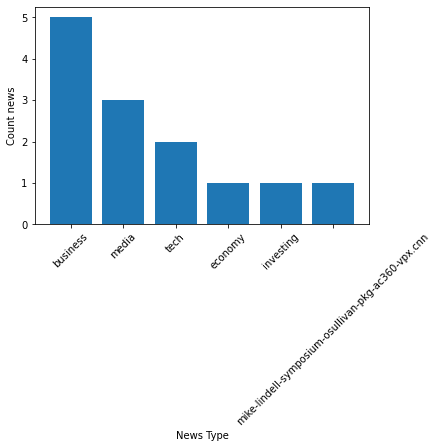

In [13]:
plot_types_of_news(news_types_frequency)

Then we want to know the date of current article. Again we can get it from article url.

In [14]:
def get_cnn_news_date(links):
    cnn_news_timestamp = []
    for link in links:
        raw_date = link[1:11]
        cnn_news_timestamp.append(raw_date.replace('/', '-'))
    return cnn_news_timestamp

In [15]:
cnn_news_timestamp = get_cnn_news_date(extracted_cnn_links)
cnn_news_timestamp

['2021-08-12',
 '2021-08-12',
 '2021-08-12',
 '2021-08-12',
 '2021-08-12',
 '2021-08-12',
 '2021-08-13',
 '2021-08-12',
 '2021-08-12',
 '2021-08-13',
 '2021-08-12',
 '2021-08-12',
 '2021-08-12']

Add domain to our links.

In [16]:
def cnn_news_add_domain(domain, links):
    for i in range(len(links)):
        links[i] = domain+links[i]

In [17]:
domain = 'https://edition.cnn.com'
cnn_news_add_domain(domain, extracted_cnn_links)
extracted_cnn_links

['https://edition.cnn.com/2021/08/12/tech/facebook-giphy-uk-cma/index.html',
 'https://edition.cnn.com/2021/08/12/business/bill-gates-infrastructure-bill-climate/index.html',
 'https://edition.cnn.com/2021/08/12/media/jeopardy-host-debacle/index.html',
 'https://edition.cnn.com/2021/08/12/tech/facebook-return-to-office-2022/index.html',
 'https://edition.cnn.com/2021/08/12/media/disney-earnings-q3-2021/index.html',
 'https://edition.cnn.com/2021/08/12/economy/july-inflation-producer-prices/index.html',
 'https://edition.cnn.com/2021/08/13/media/afghanistan-taliban-reliable-sources/index.html',
 'https://edition.cnn.com/2021/08/12/investing/premarket-stocks-trading/index.html',
 'https://edition.cnn.com/2021/08/12/business/field-of-dreams-ticket-prices/index.html',
 'https://edition.cnn.com/2021/08/13/mike-lindell-symposium-osullivan-pkg-ac360-vpx.cnn',
 'https://edition.cnn.com/2021/08/12/business/perfect-day-dairy-protein-hnk-intl-spc/index.html',
 'https://edition.cnn.com/2021/08/12/

With proper links we can now extract articles headlines.

In [18]:
def get_cnn_news_headlines(links):
    cnn_news_headlines = []
    for link in links:
        page = get_page_content(link)
        soup = create_soup(page)
        cnn_news_headlines.append(soup.find('h1').text)
    return cnn_news_headlines

In [19]:
cnn_news_headlines = get_cnn_news_headlines(extracted_cnn_links)
cnn_news_headlines

['Facebook could be forced to sell off GIF platform Giphy in response to UK regulators',
 'Bill Gates pledges $1.5 billion to climate projects in the infrastructure bill',
 "How 'Jeopardy!' got the host decision so, so wrong",
 'Facebook pushes its office reopening to 2022',
 'Disney earnings exceed expectations as parks reopen and Disney+ grows',
 'Key inflation measure hits new record high — yet again',
 "Reporters describe 'palpable fear' in Afghanistan as Taliban continues to sweep across the country",
 'Inflation is spreading to more parts of the US economy',
 "If you build it, they will pay: 'Field of Dreams' tickets cost $1,400",
 'Uh-oh!',
 "This startup is creating 'real' dairy, without cows",
 'USPS wants to charge you peak shipping fees this holiday season',
 'Major companies are recruiting more HBCU grads than ever before, administrators say']

Get articless content scraping.

In [20]:
def get_cnn_news_articles_content(links):
    cnn_news_articles_content = []
    for link in links:
        page = get_page_content(link)
        soup = create_soup(page)
        text = "".join([l.text for l in soup.findAll('div', {"class": "zn-body__paragraph"})])
        cnn_news_articles_content.append(text)
    return cnn_news_articles_content

In [21]:
cnn_news_articles_content = get_cnn_news_articles_content(extracted_cnn_links)
cnn_news_articles_content

['Facebook (FB) could soon be required to spin off Giphy in response to concerns by UK regulators, and give up control of that company\'s massive library of GIFs — the animated images used by millions to express emotions and reactions across the internet. UK antitrust regulators said Thursday that the acquisition, which Facebook announced last year, risks reducing competition in advertising and social media.In a provisional finding, the UK\'s Competition and Markets Authority (CMA) said Facebook\'s control over Giphy could allow it to cut off other social media sites\' access to Giphy\'s images. Giphy\'s services currently integrate with services like Twitter, Snapchat, iMessage and Slack. The finding is a blow to Facebook\'s global aspirations amid intense antitrust scrutiny by governments around the world, and a potential red flag for other Big Tech companies pursuing acquisitions in this regulatory climate.While far from the largest deal Facebook has ever done, the Giphy acquisition

CNN ends here.

Start BBC web scraping.

Extact links from scraped data and clear duplicating, if there is such links.

After web scraping page we got unusable links like this - **/news/business-58156118/#comp-comments-button**.


Here is the part of the result:

```'/news/business',```

 ```'/news/technology-58146039',```
 
 ```'/news/technology',```
 
 ```'/news/business-58154046',```
 
 ```'/news/business-58156118/#comp-comments-button',```
 
 ```'/news/technology-58145808',```
 
 ```'/news/business-58156118', ....```
 
 
 **I can't print the daily result because I am not sure that in this current day there will be usless links**

So we need to create function which removes usless links from our result. Wait but we have already created it for cnn news same purpos.

In [22]:
def extract_bbc_links(link, domain):
    page = get_page_content(link)
    soup = create_soup(page)
    bbc_extracted_links = [l['href'] for l in soup.find('div', {'class', "gel-layout gel-layout--equal"}).find_all('a')]
    bbc_extracted_links = clear_duplicate_links(bbc_extracted_links)
    pat = r'/news/\w+[-]\d+'
    bbc_extracted_links = remove_usless_links(pat, bbc_extracted_links)
    #Add domain
    bbc_extracted_links = [domain+l for l in bbc_extracted_links]
    return bbc_extracted_links

Result:

In [23]:
extracted_bbc_links = extract_bbc_links(bbc_link, domain="https://www.bbc.com")
extracted_bbc_links

['https://www.bbc.com/news/business-58196477',
 'https://www.bbc.com/news/business-58049625',
 'https://www.bbc.com/news/business-58196473',
 'https://www.bbc.com/news/business-58123729',
 'https://www.bbc.com/news/business-58174043',
 'https://www.bbc.com/news/business-58167618',
 'https://www.bbc.com/news/business-58109993']

In [24]:
def get_bbc_news_type(links):
    news_type = []
    for l in links:
        page = get_page_content(l)
        soup = create_soup(page)
        news_type.append(soup.find('span', {'class': "ssrcss-1gr85n1-LinkTextContainer eis6szr1"}).text.lower())
    return news_type

In [25]:
bbc_news_types = get_bbc_news_type(extracted_bbc_links)
bbc_news_types

['business',
 'business',
 'business',
 'business',
 'business',
 'business',
 'business']

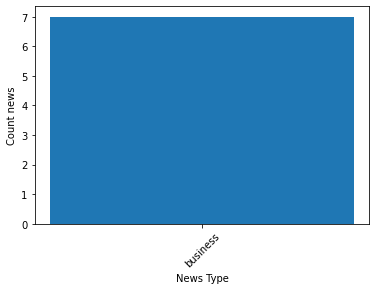

In [26]:
news_types_frequency = nltk.FreqDist(bbc_news_types)
plot_types_of_news(news_types_frequency)

In [27]:
def get_bbc_news_datetime(links):
    times = []
    for l in links:
        page = get_page_content(l)
        soup = create_soup(page)
        attributes = str(soup.find('time'))
        pat = r'\d{4}-\d{2}-\d{2}'
        obj = re.findall(pat, attributes)
        times.append(obj[0])
    return times

In [28]:
bbc_news_timestamp = get_bbc_news_datetime(extracted_bbc_links)
bbc_news_timestamp

['2021-08-13',
 '2021-08-12',
 '2021-08-13',
 '2021-08-12',
 '2021-08-12',
 '2021-08-13',
 '2021-08-06']

In [29]:
def get_bbc_news_headlines(links):
    headlines = []
    for l in links:
        page = get_page_content(l)
        soup = create_soup(page)
        headlines.append(soup.find('h1').text)
    return headlines

In [30]:
bbc_news_headlines = get_bbc_news_headlines(extracted_bbc_links)
bbc_news_headlines

['Ningbo: Global supply fears as China partly shuts major port',
 'How can new technology protect outdoor workers?',
 'Lord of the Rings: Amazon moves show to UK from New Zealand',
 'Can Americans pull the plug on petrol-powered cars?',
 'The $8bn EV company youâ\x80\x99ve probably never heard of',
 'Firms want help to measure their carbon footprint',
 'South Park creators sign $900m deal to make seasons and movies']

In [31]:
def get_bbc_news_articles_content(links):
    content = []
    for l in links:
        page = get_page_content(l)
        soup = create_soup(page)
        content.append("".join([line.text for line in soup.find_all('div', {'data-component':"text-block"})]))
    return content

In [32]:
bbc_news_articles_content = get_bbc_news_articles_content(extracted_bbc_links)
bbc_news_articles_content

['The partial closure of one of China\'s biggest cargo ports due to coronavirus has raised fresh concerns about the impact on global trade. Services were shut on Wednesday at a terminal at Ningbo-Zhoushan port after a worker was infected with the Delta variant of Covid-19.Ningbo-Zhoushan in eastern China is the world\'s third-busiest cargo port.The closure threatens more disruption to supply chains ahead of the key Christmas shopping season.Closing the terminal on Meishan island until further notice will cut the port\'s capacity for container cargo by about a quarter.It comes as the cost of shipping from China and South East Asia to the East coast of the US has already hit a record high, according to the Freightos Baltic global container freight index.And some UK businesses were already feeling the pressure of much higher shipping costs.Jason Chiang from Ocean Shipping Consultants told the BBC\'s Asia Business Report that the global shipping industry is likely to feel the impact of the

For more clarity we want to get our data to DataFrame. For now we want to have columns for article headline, context, date and type.

For that we need to get content and headline from every article. We already have article type and date.

###### 2. Data processing

But firstly we have saved data from previous days. So let's get DataFrame and than add new data.

DF is stored in **data** folder into csv file.

In [33]:
def get_dataframe_from_csv(path):
    df = pd.read_csv(path)
    return df

One big problem occurs when we run this notebook several times in one day. We will add the same rows. So let's make function that removes diplicating rows.

In [34]:
def remove_duplicating_rows(dataframe):
    duplicated = dataframe[dataframe.duplicated()]
    dataframe.drop(duplicated.index, axis=0, inplace=True)
    return dataframe.reset_index(drop=True)

We want just news about business, investing, tech and economy. Create function remove_usless_news().

In [35]:
def remove_usless_news(dataframe):
    #Yes it is ugly but it is working
    dataframe.drop(dataframe[(dataframe['news_type'] != 'business') &  (dataframe['news_type'] != 'tech') & (dataframe['news_type'] != 'investing') & (dataframe['news_type'] != 'economy')].index, axis=0, inplace=True)
    return dataframe.reset_index(drop=True)

We have our dates, types, content and headline and now is time to add them to dataframe.

Add BBC or CNN news to dataframe.

In [36]:
def add_bbc_or_cnn_news_to_dataframe(dataframe, data, source):
    for i in range(0, len(data[0])):
        dataframe.loc[len(dataframe)] = [data[0][i], data[1][i], data[2][i], data[3][i], source]
    dataframe['date'] = pd.to_datetime(dataframe['date'])

In [37]:
filename = 'news'
path = 'data/'+filename
text_data = get_dataframe_from_csv(path)
cnn_data = [cnn_news_headlines, cnn_news_articles_content, cnn_news_timestamp, cnn_news_types]
bbc_data = [bbc_news_headlines, bbc_news_articles_content, bbc_news_timestamp, bbc_news_types]
add_bbc_or_cnn_news_to_dataframe(text_data, cnn_data, "CNN")
add_bbc_or_cnn_news_to_dataframe(text_data, bbc_data, "BBC")

In [38]:
text_data = remove_duplicating_rows(text_data)
text_data = remove_usless_news(text_data)

In [39]:
text_data

,headline,content,date,news_type,source
0,Alibaba fires employee accused of sexual assau...,The company on Monday said it has fired an emp...,2021-08-09,tech,CNN
1,Twitter suspends Marjorie Taylor Greene's acco...,Greene tweeted on Monday that the Food and Dru...,2021-08-10,tech,CNN
2,Why Silicon Valley is betting on making this d...,The metaverse was originally conceived as the ...,2021-08-08,tech,CNN
3,AMC is playing to the Reddit crowd,A version of this story first appeared in CNN ...,2021-08-10,investing,CNN
4,SoftBank's CEO went big on China. Now he's pul...,The Japanese billionaire said at an earnings p...,2021-08-10,investing,CNN
...,...,...,...,...,...
86,Ningbo: Global supply fears as China partly sh...,The partial closure of one of China's biggest ...,2021-08-13,business,BBC
87,Ningbo: Global supply fears as China partly sh...,The partial closure of one of China's biggest ...,2021-08-13,business,BBC
88,Lord of the Rings: Amazon moves show to UK fro...,Technology giant Amazon's TV and film business...,2021-08-13,business,BBC
89,The $8bn EV company youâve probably never he...,,2021-08-12,business,BBC


Save changed DF to .csv file

In [40]:
def save_dataframe_to_csv(dataframe, filename):
    path = "data/" + filename
    dataframe.to_csv(path, index=False)

In [41]:
save_dataframe_to_csv(text_data, 'news')

Types of DataFrame are:

In [42]:
text_data.dtypes

headline             object
content              object
date         datetime64[ns]
news_type            object
source               object
dtype: object

Content from first article:

In [43]:
content = text_data.loc[0]['content']
print(text_data.loc[0]['headline'])

Alibaba fires employee accused of sexual assault as pressure mounts on Chinese tech


###### 3.Text Analisys

It every text there are stopwords - high-frequency words like the, to, and, also, that. We sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts.

So we  will remove them from this article.

Firstly let's see what english stopwords are. NLTK library has a built-in module with stopwords.

In [44]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [45]:
content[:1200]

'The company on Monday said it has fired an employee after he was accused of sexually assaulting a woman who also works at Alibaba (BABA). The man confessed to actions that Alibaba deemed "in serious violation of company policy," according to a memo sent by Alibaba Group chairman and CEO Daniel Zhang to employees.Two senior employees also resigned after they "failed to prioritize employee protection," according to Zhang\'s memo."Alibaba Group has a zero-tolerance policy against sexual misconduct, and ensuring a safe workplace for all our employees is Alibaba\'s top priority," a company spokesperson said in a statement to CNN Business.The allegations — which were widely circulated on Chinese social media over the weekend — have rocked Alibaba at a time when it and other Chinese tech companies are already facing incredible scrutiny from Chinese regulators over their business. The claims triggered public outcry as many criticized the company for its handling of the situation. The controve

if we discover the text more carefully to see that some sentences are merged. There is no space after some of punctuation marks, like: a company spokesperson said in a statement to CNN **Business.The** allegations — which were widely circulated on Chinese social media over the weekend. If we tokenize this sentence we will have ```Business.The``` as token. We do not want that to happen so we will use WordPunktTokenizer.

In [46]:
def add_whitespace_after_punctuation_mark(text):
    for i in range(0,len(text) - 2):
        if text[i] in '.?!':
            if text[i+1] != ' ' and text[i+1] not in '.?!':
                text = text[:i+1] + ' ' + text[i+1:]
    return text

In [47]:
text = add_whitespace_after_punctuation_mark(content)
text

'The company on Monday said it has fired an employee after he was accused of sexually assaulting a woman who also works at Alibaba (BABA). The man confessed to actions that Alibaba deemed "in serious violation of company policy," according to a memo sent by Alibaba Group chairman and CEO Daniel Zhang to employees. Two senior employees also resigned after they "failed to prioritize employee protection," according to Zhang\'s memo. "Alibaba Group has a zero-tolerance policy against sexual misconduct, and ensuring a safe workplace for all our employees is Alibaba\'s top priority," a company spokesperson said in a statement to CNN Business. The allegations — which were widely circulated on Chinese social media over the weekend — have rocked Alibaba at a time when it and other Chinese tech companies are already facing incredible scrutiny from Chinese regulators over their business. The claims triggered public outcry as many criticized the company for its handling of the situation. The contr

Now ```Business. The``` is OK.

Tokenize our text into words. 

In [48]:
def tokenize_text(text):
    return WordPunctTokenizer().tokenize(text)

In [49]:
tokens = tokenize_text(text)
tokens

['The',
 'company',
 'on',
 'Monday',
 'said',
 'it',
 'has',
 'fired',
 'an',
 'employee',
 'after',
 'he',
 'was',
 'accused',
 'of',
 'sexually',
 'assaulting',
 'a',
 'woman',
 'who',
 'also',
 'works',
 'at',
 'Alibaba',
 '(',
 'BABA',
 ').',
 'The',
 'man',
 'confessed',
 'to',
 'actions',
 'that',
 'Alibaba',
 'deemed',
 '"',
 'in',
 'serious',
 'violation',
 'of',
 'company',
 'policy',
 ',"',
 'according',
 'to',
 'a',
 'memo',
 'sent',
 'by',
 'Alibaba',
 'Group',
 'chairman',
 'and',
 'CEO',
 'Daniel',
 'Zhang',
 'to',
 'employees',
 '.',
 'Two',
 'senior',
 'employees',
 'also',
 'resigned',
 'after',
 'they',
 '"',
 'failed',
 'to',
 'prioritize',
 'employee',
 'protection',
 ',"',
 'according',
 'to',
 'Zhang',
 "'",
 's',
 'memo',
 '.',
 '"',
 'Alibaba',
 'Group',
 'has',
 'a',
 'zero',
 '-',
 'tolerance',
 'policy',
 'against',
 'sexual',
 'misconduct',
 ',',
 'and',
 'ensuring',
 'a',
 'safe',
 'workplace',
 'for',
 'all',
 'our',
 'employees',
 'is',
 'Alibaba',
 "'",

Remove stopwords and non alphabetic words then we will set every word in lower case. There are gonna be two or more occurences for one word - ```like and Like```, if we don't set words to lower case. That is why we want every single word to be in lower case so the analysis will be more accurate.

In [50]:
def get_meaningful_words(words):
    meaningful_words = []
    for w in words:
        if w.lower() not in stopwords.words('english') and w.lower().isalpha():
            meaningful_words.append(w.lower())
    return meaningful_words

In [51]:
meaningful_words = get_meaningful_words(tokens)
meaningful_words

['company',
 'monday',
 'said',
 'fired',
 'employee',
 'accused',
 'sexually',
 'assaulting',
 'woman',
 'also',
 'works',
 'alibaba',
 'baba',
 'man',
 'confessed',
 'actions',
 'alibaba',
 'deemed',
 'serious',
 'violation',
 'company',
 'policy',
 'according',
 'memo',
 'sent',
 'alibaba',
 'group',
 'chairman',
 'ceo',
 'daniel',
 'zhang',
 'employees',
 'two',
 'senior',
 'employees',
 'also',
 'resigned',
 'failed',
 'prioritize',
 'employee',
 'protection',
 'according',
 'zhang',
 'memo',
 'alibaba',
 'group',
 'zero',
 'tolerance',
 'policy',
 'sexual',
 'misconduct',
 'ensuring',
 'safe',
 'workplace',
 'employees',
 'alibaba',
 'top',
 'priority',
 'company',
 'spokesperson',
 'said',
 'statement',
 'cnn',
 'business',
 'allegations',
 'widely',
 'circulated',
 'chinese',
 'social',
 'media',
 'weekend',
 'rocked',
 'alibaba',
 'time',
 'chinese',
 'tech',
 'companies',
 'already',
 'facing',
 'incredible',
 'scrutiny',
 'chinese',
 'regulators',
 'business',
 'claims',
 't

Ratio of meaningful words compared to all words in text is:

In [52]:
def meaningful_to_all_words(meaningful_words, text):
    return len(meaningful_words) / len(text.split())

In [53]:
meaningful_to_all_words(meaningful_words, text)

0.5534729878721059

This result shows how useful it is tokenize text, remove stop words, punctuation, and change uppercase to lowercase. This way we save time and memory. Mostly time, because if we prepare the data for some kind of modeling we will have less information, but at the expense of more accurate and specific data for the text.

Create FreqList with cleaned words.

In [54]:
def get_words_frequency(words):
    return nltk.FreqDist(words)

In [55]:
freq_words = get_words_frequency(meaningful_words)
freq_words

FreqDist({'company': 14, 'employees': 13, 'alibaba': 12, 'zhang': 10, 'business': 7, 'culture': 7, 'woman': 6, 'chinese': 6, 'wrote': 6, 'said': 5, ...})

Let's take a closer look at the dictionary of common words. In fact, let's plot some of them using barchart. Let's look at a small hypothesis. Are there words that are outliers. That is, whether there are several words that are repeated more than other words

In [56]:
def plot_most_frequent_words(words_number, freq_words):
    most_common_words = freq_words.most_common(words_number)
    plt.bar([w[0] for w in most_common_words], [w[1] for w in most_common_words])

    plt.title(f"Top {words_number} most frequent words count")
    plt.xlabel("Words")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

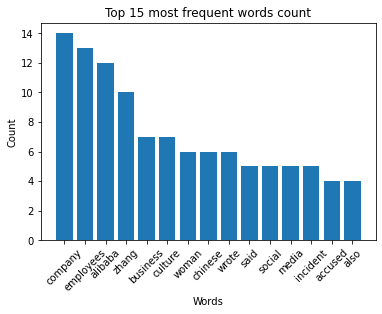

In [57]:
freq_words
number_words = 15
plot_most_frequent_words(number_words, freq_words)

After the observation, the hypothesis seems to be true, but let's set the words by their count

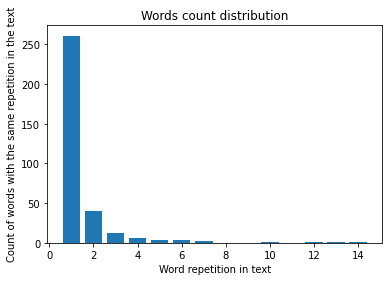

In [58]:
words_freq_count = collections.Counter(freq_words.values())
plt.bar(words_freq_count.keys(), words_freq_count.values())

plt.title(f"Words count distribution")
plt.xlabel("Word repetition in text")
plt.ylabel("Count of words with the same repetition in the text")
plt.show()

Yes, we can now conclude that there are several words that are repeated a lot in the text

In [59]:
def get_text_sentences(text):
    return sent_tokenize(text.replace('"', '').replace(',', ''))

In [60]:
sentences = get_text_sentences(text)
sentences

['The company on Monday said it has fired an employee after he was accused of sexually assaulting a woman who also works at Alibaba (BABA).',
 'The man confessed to actions that Alibaba deemed in serious violation of company policy according to a memo sent by Alibaba Group chairman and CEO Daniel Zhang to employees.',
 "Two senior employees also resigned after they failed to prioritize employee protection according to Zhang's memo.",
 "Alibaba Group has a zero-tolerance policy against sexual misconduct and ensuring a safe workplace for all our employees is Alibaba's top priority a company spokesperson said in a statement to CNN Business.",
 'The allegations — which were widely circulated on Chinese social media over the weekend — have rocked Alibaba at a time when it and other Chinese tech companies are already facing incredible scrutiny from Chinese regulators over their business.',
 'The claims triggered public outcry as many criticized the company for its handling of the situation.'

In [61]:
def get_sentences_score(sentences, freq_words):
    sentence_value = dict()

    for sentence in sentences:
        sentence_without_end_point = sentence[:-1]
        words = sentence_without_end_point.split()
        for w in words:
            w = w.lower()
            if w in freq_words.keys():
                if sentence in sentence_value.keys():
                    sentence_value[sentence] += freq_words[w]
                else:
                    sentence_value[sentence] = freq_words[w]
    return sentence_value

In [62]:
sentences_score = get_sentences_score(sentences, freq_words)
sentences_score.values()

dict_values([55, 88, 37, 71, 66, 25, 53, 35, 13, 5, 11, 16, 15, 20, 19, 34, 29, 22, 19, 13, 8, 31, 14, 16, 6, 67, 35, 21, 69, 58, 8, 19, 80, 50, 32, 25, 41, 23, 14, 67, 87, 43])

We want to get words 'values' for count of words in sentence. Because in too long sentence we expect bigger value just because there are more words. To solve this problem we will divide words score in the sentence by meaningful words count in this sentence.

In [63]:
def get_sentence_score_frequency(sentence_value, meaningful_words):
    word_score_frequency = {}
    for k, v in sentence_value.items():
        meaningful_words_count = 0
        for w in k.split():
            if w.lower() in meaningful_words:
                meaningful_words_count += 1
        word_score_frequency[k] = v / meaningful_words_count
    return word_score_frequency

In [64]:
sentence_score_frequency = get_sentence_score_frequency(sentences_score, meaningful_words)
sentence_score_frequency.values()

dict_values([4.583333333333333, 4.888888888888889, 3.7, 4.4375, 3.473684210526316, 3.125, 3.3125, 2.5, 1.1818181818181819, 1.25, 2.75, 1.6, 3.0, 5.0, 2.111111111111111, 5.666666666666667, 4.142857142857143, 2.75, 19.0, 4.333333333333333, 1.1428571428571428, 7.75, 2.0, 2.2857142857142856, 3.0, 5.153846153846154, 2.3333333333333335, 5.25, 3.8333333333333335, 3.2222222222222223, 2.0, 4.75, 3.8095238095238093, 2.9411764705882355, 2.2857142857142856, 2.5, 2.5625, 1.2105263157894737, 3.5, 3.35, 3.9545454545454546, 2.6875])

Now the result is a little bit different. Let's plot the two results and see what are the differences between them.

In [65]:
def hist_plot(score, color, density):
    plt.hist(score, color=color, density=density)
    
    plt.title(f"Score values")
    plt.xlabel("Points for sentence")
    plt.ylabel("Sentences count")
    
    plt.show()

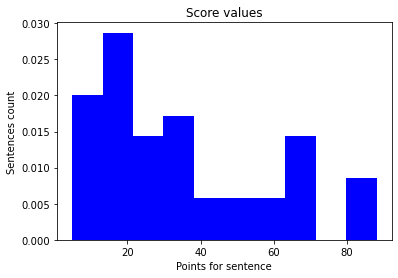

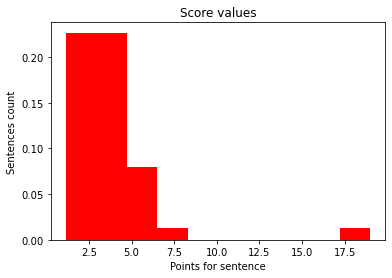

In [66]:
hist_plot(sentences_score.values(), 'b', True)
hist_plot(sentence_score_frequency.values(), 'r', True)

We can see that their distributions, peeks and mean value are different. Now let's do another plot.


In [67]:
def compare_two_score_lists(first_score, transformed_score):
    first_score = np.array(list(first_score))
    first_score = np.log10(first_score)
    
    transformed_score = np.array(list(transformed_score))
    transformed_score = np.log10(transformed_score)
    plt.hist(first_score, alpha=0.7)
    plt.hist(transformed_score, color='r', alpha=0.6)
    
    plt.title(f"First score values")
    plt.xlabel("Sentences count")
    plt.ylabel("Points for sentence")
    plt.show()

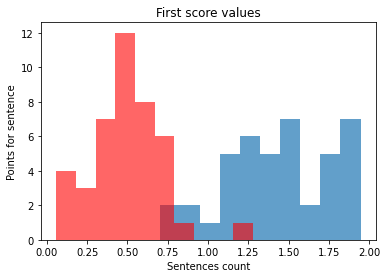

In [68]:
compare_two_score_lists(sentences_score.values(), sentence_score_frequency.values())

In [69]:
np.corrcoef(list(sentences_score.values()), list(sentence_score_frequency.values()))

array([[1.       , 0.1008634],
       [0.1008634, 1.       ]])

I used logaritm to normalize score in range $ [0, 2] $, because our function valuse(scores) are with different ranges - sentence_score $\in [0, 10] $ and sentence_score_frequency $\in [0, 90] $ After looking at the plot bar chart it is obvious that their distributions are different. Correlation between them aren'tbig enough to say that if value changes in sentences_score than it will change value from sentence_score_frequency in the same. We could conclude that behaviour of sentences_score is different from sentence_score_frequency's behaviour. So we need to perform summarization with both scores and establish which score is better.

In [70]:
def perform_summarization(score, sentences=None, words_ratio=None):
    
    dataframe = pd.DataFrame(list(score.items()), columns=["sentence", "score"])
    dataframe["sorted_score_index"] = np.zeros(len(dataframe.sentence)).astype("int64")
    for i, s in enumerate(dataframe["score"].sort_values(ascending=False)):
        dataframe.loc[dataframe["score"] == s, "sorted_score_index"] = i
    
    summarized_sentences_count = 0
    
    if sentences != None:
        sentences_main_text = len(score.keys())
        if sentences <= 0  or sentences > sentences_main_text:
            print(f"Sentences can be within 1 and {sentences_main_text}")

        summarized_sentences_count = sentences
            
    else:
        if words_ratio != None:
            for s in dataframe["sorted_score_index"].sort_values().index:
                sentence_words_count = len(dataframe.loc[s, "sentence"].split())
                words_ratio -= sentence_words_count
                summarized_sentences_count += 1
                if words_ratio < 0:
                    break
                    
        else:
            print("Ratio arguments are none!")
          
        
    if summarized_sentences_count == 0:
        summarized_sentences_count = 1
        
    summarized_text = []
    for index in range(0, len(dataframe)):
        if dataframe.loc[index, "sorted_score_index"] < summarized_sentences_count:
             summarized_text.append(dataframe.loc[index, "sentence"])
    return " ".join(summarized_text)

In [71]:
def print_lenght_summarized_and_content(summarized_text, content):
    print(f"Lenght of summarized text is {len(summarized_text)}, Count of words = {len(summarized_text.split())}, Sentences count = {len(sent_tokenize(summarized_text))}. Lenght of text is {len(content)}, Count of words {len(content.split())}, Sentences count = {len(sent_tokenize(content))}.")

In this function we will get sentences score and ratio of summarization. Firstly we have to establish sentences count than get summarized text sentences by multiplying sentences count and sentences ratio. After that we will store sencenses and their scores and their sorted score index to dataframe. For every sentence, if sentence's sorted_score_index is in range $\in [0$, summarized text sentences count $]$, append sentence to summarized text. Important think to add is that we need to start iterating through sentences in acsending order, because if we start with the sentence with the biggest score, we could lose information(context) from sentences above, if any avaliable. Second summarization method is summarizing using word_ratio. We will extract count words in top scored sentences from words ratio. Then fro every extraction we will add one sentence to summarized text, again starting from the begining.

In [72]:
summarized_text = perform_summarization(sentences_score, words_ratio = 100)
summarized_text

"The man confessed to actions that Alibaba deemed in serious violation of company policy according to a memo sent by Alibaba Group chairman and CEO Daniel Zhang to employees. Zhang added that the company's chief people officer has also been reprimanded and said that the company will establish a dedicated reporting channel for employees as well as create an anti-sexual harassment policy that will include input from experts and employees. Chinese social media users started calling out the deaths as emblematic of a troublesome work culture and a former software engineer at the company escalated criticisms in several posts where he accused the company of overworking its employees."

In [73]:
print_lenght_summarized_and_content(summarized_text, text)

Lenght of summarized text is 684, Count of words = 108, Sentences count = 3. Lenght of text is 5600, Count of words 907, Sentences count = 42.


Now let's use sentence_score_frequency as score parameter in perform_summarization function to see the differences between two extracted scores.

In [74]:
summarized_text = perform_summarization(sentence_score_frequency, 2)
summarized_text

'Is this the Alibaba culture? Such a large company must protect its employees.'

In [75]:
print_lenght_summarized_and_content(summarized_text, text)

Lenght of summarized text is 77, Count of words = 13, Sentences count = 2. Lenght of text is 5600, Count of words 907, Sentences count = 42.


The problem is text lenghts are different, so we might summarize text using word lenght ratio.

In [76]:
summarized_text_words_ratio_normal_score = perform_summarization(sentences_score, 42)
summarized_text_words_ratio_normal_score

"The company on Monday said it has fired an employee after he was accused of sexually assaulting a woman who also works at Alibaba (BABA). The man confessed to actions that Alibaba deemed in serious violation of company policy according to a memo sent by Alibaba Group chairman and CEO Daniel Zhang to employees. Two senior employees also resigned after they failed to prioritize employee protection according to Zhang's memo. Alibaba Group has a zero-tolerance policy against sexual misconduct and ensuring a safe workplace for all our employees is Alibaba's top priority a company spokesperson said in a statement to CNN Business. The allegations — which were widely circulated on Chinese social media over the weekend — have rocked Alibaba at a time when it and other Chinese tech companies are already facing incredible scrutiny from Chinese regulators over their business. The claims triggered public outcry as many criticized the company for its handling of the situation. The controversy start

In [77]:
print_lenght_summarized_and_content(summarized_text_words_ratio_normal_score, text)

Lenght of summarized text is 5512, Count of words = 906, Sentences count = 42. Lenght of text is 5600, Count of words 907, Sentences count = 42.


In [78]:
summarized_text_words_ratio_frequency_score = perform_summarization(sentence_score_frequency, 42)
summarized_text_words_ratio_frequency_score

"The company on Monday said it has fired an employee after he was accused of sexually assaulting a woman who also works at Alibaba (BABA). The man confessed to actions that Alibaba deemed in serious violation of company policy according to a memo sent by Alibaba Group chairman and CEO Daniel Zhang to employees. Two senior employees also resigned after they failed to prioritize employee protection according to Zhang's memo. Alibaba Group has a zero-tolerance policy against sexual misconduct and ensuring a safe workplace for all our employees is Alibaba's top priority a company spokesperson said in a statement to CNN Business. The allegations — which were widely circulated on Chinese social media over the weekend — have rocked Alibaba at a time when it and other Chinese tech companies are already facing incredible scrutiny from Chinese regulators over their business. The claims triggered public outcry as many criticized the company for its handling of the situation. The controversy start

In [79]:
print_lenght_summarized_and_content(summarized_text_words_ratio_frequency_score , text)

Lenght of summarized text is 5512, Count of words = 906, Sentences count = 42. Lenght of text is 5600, Count of words 907, Sentences count = 42.


Summarized texts using words ratio are looking pretty much the same. I campared summarized texts on this site (Text Comparator)(https://copyleaks.com/text-compare). Result was: 60.2% identity. But now  let's make function which compares them and returns the differing sentences and do the job be our own.

In [80]:
def compare_two_summarized_texts(summarized_text_one, summarized_text_two):
    sentences_text_one = sent_tokenize(summarized_text_one)
    sentences_text_two = sent_tokenize(summarized_text_two)
    return " ".join(set(sentences_text_one).symmetric_difference(set(sentences_text_two)))

In [81]:
different_summarized_text = compare_two_summarized_texts(summarized_text_words_ratio_normal_score, summarized_text_words_ratio_frequency_score)
different_summarized_text
#print_lenght_summarized_and_content(different_summarized_text, content)

''

We got the differences between two summarizations now let's get identical parts of them.

In [82]:
def get_identical_sentences_from_two_summarized_texts(summarized_text_one, summarized_text_two):
    sentences_text_one = sent_tokenize(summarized_text_one)
    sentences_text_two = sent_tokenize(summarized_text_two)
    return " ".join(set(sentences_text_one).intersection(set(sentences_text_two)))

In [83]:
identical_summarized_text = get_identical_sentences_from_two_summarized_texts(summarized_text_words_ratio_normal_score, summarized_text_words_ratio_frequency_score)
identical_summarized_text
#print_lenght_summarized_and_content(identical_summarized_text, content)

"I never thought that I would have such an experience she wrote. Chinese social media users started calling out the deaths as emblematic of a troublesome work culture and a former software engineer at the company escalated criticisms in several posts where he accused the company of overworking its employees. In the memo to employees on Monday Zhang said the employee confessed to intimate acts with a woman who was inebriated violating company policy. Whether he has committed rape or indecency that violates the law will be determined by law enforcement Zhang added in the memo which was posted publicly on the company's news website. When I typed the lines above I couldn't control myself and I broke into tears. wrote one Weibo user. Complaints about work culture play into that scrutiny. According to screenshots of the 8000-word account the woman claimed she was assaulted by her supervisor during a business trip to Jinan a city in eastern China while she says she was drunk. Topics related t

In [84]:
compare_two_summarized_texts(summarized_text_words_ratio_normal_score, identical_summarized_text).split(". ")

['']

Now we have the tools to extract differences and identity, so let's make function that plots the division between identity and differences in each text for every summarization in range for word_ratio $ \in (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)$.

Hypothesis: When the lenght of the summarization text increaces, identity between two summarized texts, established from the two different scores is incresing and the difference between texts is decreacing.

In [85]:
def view_over_the_different_word_ratios(first_score, second_score, main_text, sentences=False, ratio_range=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], bar_width=1):
    
    results_from_word_ratios_one = {}
    results_from_word_ratios_two = {}
    for r in ratio_range:
        word_ratio = int(r * len(main_text.split()))
        sentence = None
        if sentences == True:
            word_ratio = None
            sentence = r
        #summarize using two scores
        summarization_one = perform_summarization(first_score, sentences=sentence, words_ratio=word_ratio)
        summarization_two = perform_summarization(second_score, sentences=sentence, words_ratio=word_ratio)
        
        #Get identical text
        identical_summarized_text = get_identical_sentences_from_two_summarized_texts(summarization_one, summarization_two)
        
        #Get difference from summarized text and identical text 
        difference_summarization_one = compare_two_summarized_texts(summarization_one, identical_summarized_text)
        difference_summarization_two = compare_two_summarized_texts(summarization_two, identical_summarized_text)
        
        #Count of words in difference from summarized text and identical text 
        sents_difference_summarization_one = len(difference_summarization_one.split(". "))
        sents_difference_summarization_two = len(difference_summarization_two.split(". "))
        sents_in_identical_summarization = len(identical_summarized_text.split(". "))
        
        if sents_in_identical_summarization == 0:
            
            results_from_word_ratios_one[r] = 0 
            results_from_word_ratios_two[r] = 0
        elif difference_summarization_one.count('') == 1:
            
            results_from_word_ratios_one[r] = 0
            
            if difference_summarization_two.count(''):
                results_from_word_ratios_two[r] = 0
            else:
                results_from_word_ratios_two[r] = sents_difference_summarization_two / sents_in_identical_summarization
        else:
            # find Identity to difference ratio
            results_from_word_ratios_one[r] = sents_difference_summarization_one / sents_in_identical_summarization
            results_from_word_ratios_two[r] = sents_difference_summarization_two / sents_in_identical_summarization
            
            
    fig, ax = plt.subplots()   
    ax.bar([k for k in results_from_word_ratios_one.keys()], [v for v in results_from_word_ratios_one.values()], alpha=0.5, color='b', width=bar_width)
    ax.bar([k for k in results_from_word_ratios_two.keys()], [v for v in results_from_word_ratios_two.values()], alpha=0.7, color='y', width=bar_width)
    
    plt.legend(["Summarized text one ratio", "Summarized text two ratio"])
    plt.title(f"Identity ratio in text")
    plt.xlabel("Category")
    plt.ylabel("Frequency (identity to difference)")
                                                                                                                                                
    fig.tight_layout()
    plt.show()

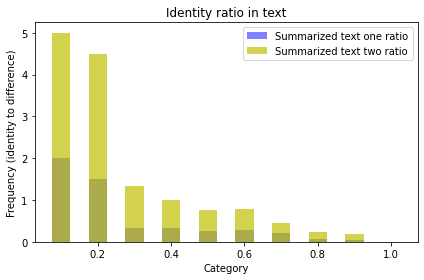

In [86]:
view_over_the_different_word_ratios(sentences_score, sentence_score_frequency, text, ratio_range=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6 ,0.7, 0.8, 0.9, 1], bar_width=0.05)

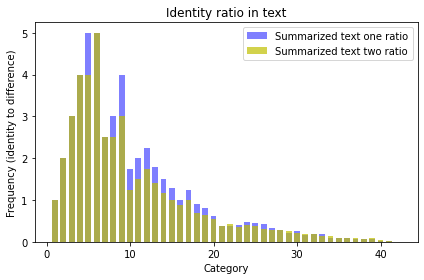

In [87]:
view_over_the_different_word_ratios(sentences_score, sentence_score_frequency, content, sentences=True, ratio_range=[x for x in range(1, 43)], bar_width=0.7)

From this plot we can prove that as we increace the total lenght of the summarized text the identity between two summarized texts, established from the two different scores is incresing and after a while they become the same This means that the summarized result from both of sentence scores is pretty much the same. I will use sentence score, because it is performing better.

###### Determine what is the text temper using classification

###### Compare my summarization with build in modules from libraries

For this purpose i will use summarization tools from sumpy. Sumpy libraray provides you several algorithms to implement Text Summarzation. I am going to use LexRank - A sentence which is similar to many other sentences of the text has a high probability of being important. The approach of LexRank is that a particular sentence is recommended by other similar sentences and hence is ranked higher.

In [88]:
def summarize_lex_rank(text, sentences):
    lex_rank_summarizer = LexRankSummarizer()
    my_parser = PlaintextParser.from_string(text,Tokenizer('english'))
    lex_rank_summarizer = LexRankSummarizer()
    lexrank_summary = lex_rank_summarizer(my_parser.document,sentences_count=sentences)

    result = []
    for sentence in lexrank_summary:
        result.append(str(sentence).replace('"', '').replace(',', ''))

    return " ".join(result)

In [89]:
sentences = 42
lexrank_summarized_text = summarize_lex_rank(text, sentences)
lexrank_summarized_text

"The company on Monday said it has fired an employee after he was accused of sexually assaulting a woman who also works at Alibaba (BABA). The man confessed to actions that Alibaba deemed in serious violation of company policy according to a memo sent by Alibaba Group chairman and CEO Daniel Zhang to employees. Two senior employees also resigned after they failed to prioritize employee protection according to Zhang's memo. Alibaba Group has a zero-tolerance policy against sexual misconduct and ensuring a safe workplace for all our employees is Alibaba's top priority a company spokesperson said in a statement to CNN Business. The allegations — which were widely circulated on Chinese social media over the weekend — have rocked Alibaba at a time when it and other Chinese tech companies are already facing incredible scrutiny from Chinese regulators over their business. The claims triggered public outcry as many criticized the company for its handling of the situation. The controversy start

Let's see my summarization

In [90]:
summarized_text_words_sentence_score = perform_summarization(sentences_score, sentences=sentences)
summarized_text_words_sentence_score

"The company on Monday said it has fired an employee after he was accused of sexually assaulting a woman who also works at Alibaba (BABA). The man confessed to actions that Alibaba deemed in serious violation of company policy according to a memo sent by Alibaba Group chairman and CEO Daniel Zhang to employees. Two senior employees also resigned after they failed to prioritize employee protection according to Zhang's memo. Alibaba Group has a zero-tolerance policy against sexual misconduct and ensuring a safe workplace for all our employees is Alibaba's top priority a company spokesperson said in a statement to CNN Business. The allegations — which were widely circulated on Chinese social media over the weekend — have rocked Alibaba at a time when it and other Chinese tech companies are already facing incredible scrutiny from Chinese regulators over their business. The claims triggered public outcry as many criticized the company for its handling of the situation. The controversy start

In [91]:
def comparation_with_lexrank(text, sentence_score, sentences):
    
    identity_sentences_count = []
    
    for sentence in sentences:
        lexrank_summarized_text = summarize_lex_rank(text, sentences=sentence)
        summarized_text = perform_summarization(sentence_score, sentences=sentence)
        identity = get_identical_sentences_from_two_summarized_texts(lexrank_summarized_text, summarized_text)
        identity_sentences_count.append(len(sent_tokenize(identity)))
    
    
    category = [x for x in sentences]  
    fig, ax = plt.subplots()
    ax.bar(category, [c for c in identity_sentences_count], alpha=0.5, color='b')
    ax.plot(category, category, color ='r')
    
    plt.legend(["Count of ident sentences", "Perfect identity"])
    plt.title("Summarization comparision")
    plt.xlabel("Sentences count")
    plt.ylabel("Identical sentences count")
    fig.tight_layout()
    
    plt.show()

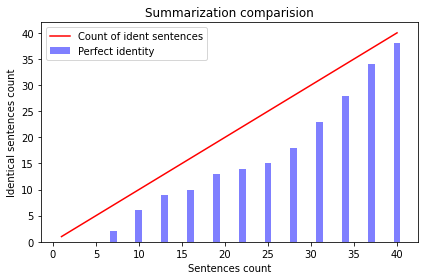

In [92]:
comparation_with_lexrank(text, sentences_score, range(1, len(sent_tokenize(text)), 3))

We plot this bar to find out if our summarization function output is the same with sumy LexRank summarizator. For every bin the red line represents full identity with LexRank. And our function is performance is great but not perfect. I think it will work for now is time to try text processing to other news.

In [93]:
def print_news_summary(dataframe, index):
    content = dataframe.loc[index, "content"]
    title = dataframe.loc[index, "headline"]
    date = dataframe.loc[index, "date"]
    news_type = dataframe.loc[index, "news_type"]
    print(f"Title: {title}")
    print(f"Date:{date}, type:{news_type}")

    text = add_whitespace_after_punctuation_mark(content)
    tokens = tokenize_text(text)
    meaningful_words = get_meaningful_words(tokens)
    freq_words = get_words_frequency(meaningful_words)
    sentences = get_text_sentences(text)
    sentences_score = get_sentences_score(sentences, freq_words)
    words_ratio, sentences_count = None, int(len(sentences) / 3)

    summarized_text = perform_summarization(sentences_score, sentences=sentences_count, words_ratio = words_ratio)
    
    print(summarized_text)
    
    print_lenght_summarized_and_content(summarized_text, text)
    
    plot_most_frequent_words(10, freq_words)
    
    comparation_with_lexrank(text, sentences_score, range(1, len(sent_tokenize(text)), 3))

###### 4. Results

Title: China sues Tencent over WeChat Youth Mode
Date:2021-08-09 00:00:00, type:tech
Beijing prosecutors have filed a civil legal action against Tencent over claims its messaging-app WeChat's Youth Mode does not comply with laws protecting minors. Youth Mode prevents younger users from accessing payments playing certain games and finding nearby friends. We will earnestly inspect and check the functions of WeChat Youth Mode accept user suggestions humbly and sincerely respond to civil public-interest litigation the company posted on Weibo. Last week Chinese authorities called for minors to be better protected from online dangers with a state-media article labelling games as spiritual opium.
Lenght of summarized text is 613, Count of words = 90, Sentences count = 4. Lenght of text is 1363, Count of words 213, Sentences count = 13.


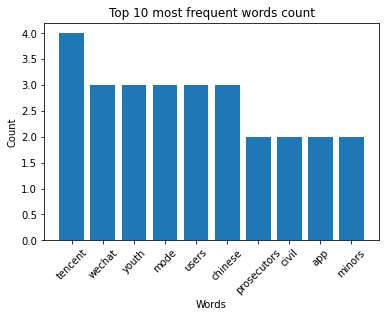

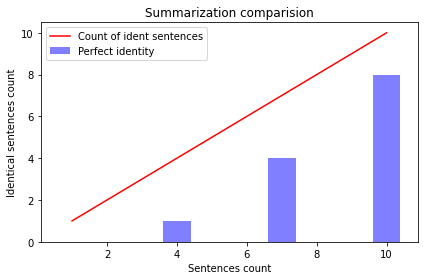

In [94]:
print_news_summary(text_data, 10)

Title: If you build it, they will pay: 'Field of Dreams' tickets cost $1,400
Date:2021-08-12 00:00:00, type:business
Baseball celebrates the myth of its rural roots tonight when the New York Yankees meet the Chicago White Sox in a game adjacent to the field in rural Dyersville Iowa population 4000 where the iconic 1989 movie Field of Dreams was filmed. Fans are paying record amounts to attend the game with most who bought tickets on the secondary market spending more than $1400 to attend. The prices are by far the highest average price ever for a regular season game and have only been topped by a handful of World Series games such as Game 4 of the 2016 World Series between two championship-starved teams as the Cleveland Indians met the Chicago Cubs at Wrigley Field in Chicago. StubHub says the average for Thursday's game on its site is $1400 while SeatGeek says the average price of tickets sold on its site is $1557. Tickets have a face value of either $375 or $425 and were sold to fans

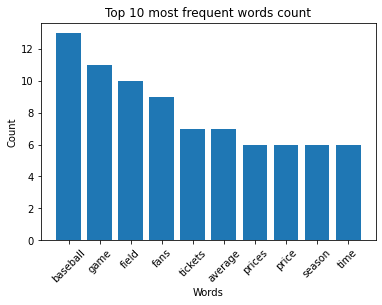

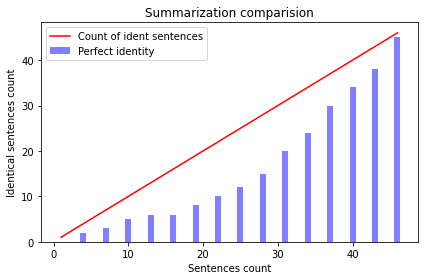

In [96]:
print_news_summary(text_data, random.randrange(0, len(text_data), 1))

Yes, That is it. News  summarization implemented from srcatch.

### Limitations and Future Work  (Optional)

For more clearity I could refeature text_data with tokens, word frequencies, score from every sentence and summarized text. That would be usefull if you want to change this parameters and remake them and results are going to be saved so you don't have to call perform_summarization many times. Other think that is missing is text temper classiffication feature, because it is very useful to know this when you read anything. But i didn't have time.

### Conclusion

I have implemented an algorithm that summarizes news using beautiful soup for web scraping part. Pandas nad numpy were really helpful when working wiit data. For text summarization I used nltk and it's methods and classes: stopwords, word_tokenize, WordPunctTokenizer, sent_tokenize. Performing the easiest summarization algorithm was very useful, because I learned a lot of things about natural language processing and I did something useful for me.

### References

https://ocw.mit.edu/courses/biological-engineering/20-109-laboratory-fundamentals-in-biological-engineering-fall-2007/assignments/sci_writing_guid.pdf

https://tjzhifei.github.io/resources/NLTK.pdf

https://www.machinelearningplus.com/nlp/text-summarization-approaches-nlp-example/

https://www.nltk.org/howto/

https://www.geeksforgeeks.org/

https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf

https://beautiful-soup-4.readthedocs.io/en/latest/

https://pandas.pydata.org/pandas-docs/stable/